# Richardson-Lucy Algorithm - Week 3

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d as conv2
from skimage import data, color, restoration
import torch
import torch.nn.functional as F


### Use of a prebuilt RL function from the skimage library:

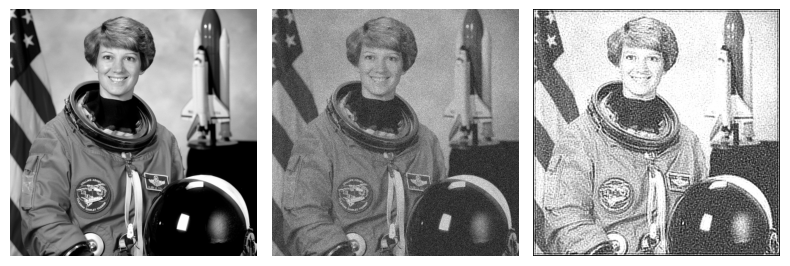

In [36]:
rng = np.random.default_rng()
image = color.rgb2gray(data.astronaut())
image_noisy = image + (rng.poisson(lam=25, size=image.shape)-10) / 50
deconvoluted_image = restoration.richardson_lucy(image_noisy, np.ones((5, 5)) / 25, num_iter=20)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 5))
ax[0].imshow(image, cmap='gray')
ax[0].axis('off')
ax[1].imshow(image_noisy, cmap='gray')
ax[1].axis('off')
ax[2].imshow(deconvoluted_image, cmap='gray')
ax[2].axis('off')
fig.tight_layout()
plt.show()

Overexposes the image and does little to reduce noise.

### Attempt at producing my own from scratch algoithm for RL:

In [111]:
def gaussian_kernel_2d(size, sigma=1.0):
    # Create a 2D gaussian kernel
    ax = torch.linspace(-(size // 2), size // 2, size)
    xx, yy = torch.meshgrid(ax, ax, indexing='ij')
    kernel = torch.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    kernel = kernel / kernel.sum()
    return kernel

def gaussian_kernel_1D(size=21, sigma=2.0):
    # Create a 1D gaussian kernel
    ax = torch.linspace(-(size // 2), size // 2, size)
    kernel = torch.exp(-0.5 * (ax / sigma) ** 2)
    kernel = kernel / kernel.sum()
    return kernel

def poisson_noise(image, scale_factor=1000):
    photon_counts = image * scale_factor
    noisy_photons = torch.poisson(photon_counts)
    noisy_image = noisy_photons / scale_factor
    return torch.clamp(noisy_image, 0, 1)


def convo1d(image, kernel):
    # Ensure image is 3D: [batch, channel, length]
    if image.dim() == 1:
        image = image.unsqueeze(0).unsqueeze(0)  # [L] -> [1, 1, L]
    elif image.dim() == 2:
        image = image.unsqueeze(0)  # [C, L] -> [1, C, L]
    
    # Ensure kernel is 3D: [out_channels, in_channels, kernel_length]
    if kernel.dim() == 1:
        kernel = kernel.unsqueeze(0).unsqueeze(0)  # [L] -> [1, 1, L]
    elif kernel.dim() == 2:
        kernel = kernel.unsqueeze(0)  # [C, L] -> [1, C, L]
    
    padding = (kernel.shape[-1] - 1) // 2
    result = torch.nn.functional.conv1d(image, kernel, padding=padding)
    
    # Return as 1D if input was 1D
    return result.squeeze()

def convo2d(image, kernel):
    if image.dim() == 2:
        image = image.unsqueeze(0).unsqueeze(0)
    elif image.dim() == 3:
        image = image.unsqueeze(0)
    
    if kernel.dim() == 2:
        kernel = kernel.unsqueeze(0).unsqueeze(0) 
    elif kernel.dim() == 3:
        kernel = kernel.unsqueeze(0)  
    
    padding = ((kernel.shape[-2] - 1) // 2, (kernel.shape[-1] - 1) // 2)
    
    filtered = F.conv2d(image, kernel, stride=1, padding=padding)
    
    
    return filtered.squeeze(0).squeeze(0)

def richardson_lucy(degr_image, kernel, num_its, estimate=None, c = 1e-10):
    if estimate is None:
        estimate = torch.ones(size=degr_image.shape)
    else:
        estimate = estimate.clone()
    

    if len(kernel.shape) == 1:
        kernel_mirror = torch.flip(kernel, [0])
        conv_func = convo1d
    elif len(kernel.shape) == 2:
        kernel_mirror = torch.flip(kernel, [-1, 0])
        conv_func = convo2d
    else:
        raise ValueError("Kernel must be 1D or 2D tensor")

    for _ in range(num_its):
        blurred_estimate = conv_func(estimate, kernel)
        blurred_estimate = torch.clamp(blurred_estimate, min=c)
        ratio = degr_image / blurred_estimate
        estimate = estimate * conv_func(ratio, kernel_mirror)
        estimate = torch.clamp(estimate, min=0)

    return estimate 


def richardson_lucy_1d(degr_image, kernel, num_its, estimate=None, c=1e-8):
    if estimate is None:
        estimate = torch.ones_like(degr_image)
    else:
        estimate = estimate.clone()

    kernel_mirror = torch.flip(kernel, [-1])

    for _ in range(num_its):
        blurred_estimate = convo1d(estimate, kernel)
        relative_blur = degr_image / (blurred_estimate + c)
        correction = convo1d(relative_blur, kernel_mirror)
        estimate = estimate * correction
        estimate = torch.clamp(estimate, min=0)

    return estimate

def deconvolution(blurred_image, kernel, epsilon=1e-5):
    # Compute Fourier transforms
    P_blurred = torch.fft.fft2(blurred_image)
    B = torch.fft.fft2(kernel.squeeze(), s=blurred_image.shape)
    
    # Avoid division by zero by adding a small constant (epsilon)
    B_conj = torch.conj(B)
    B_magnitude_squared = torch.abs(B)**2
    B_inv = B_conj / (B_magnitude_squared + epsilon)
    
    # Perform deconvolution in the frequency domain
    P_deblurred = P_blurred * B_inv

    # Inverse Fourier transform to get the deblurred image
    deblurred_image = torch.fft.ifft2(P_deblurred).real
    
    return torch.clamp(deblurred_image, 0, 1)


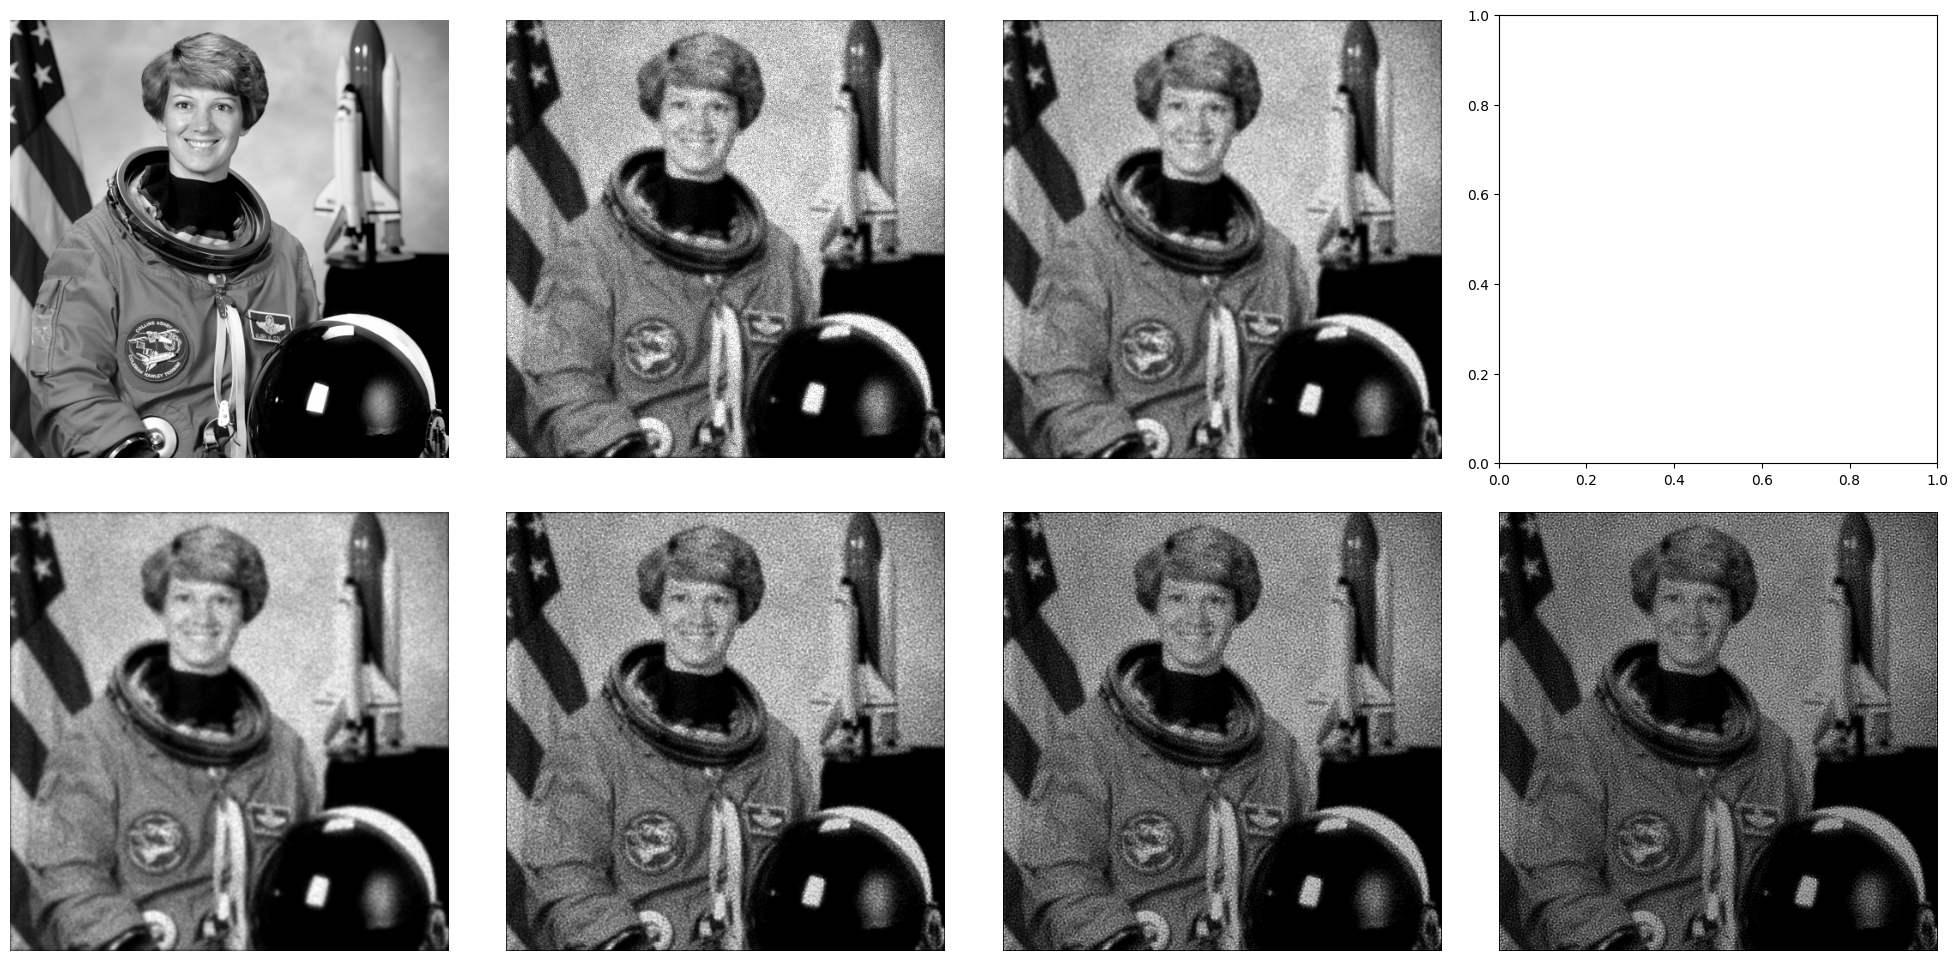

In [99]:
kernel = gaussian_kernel_2d(5, sigma=1.0)
image_tensor = torch.tensor(image, dtype=torch.float32)
image_noisy = convo2d(image_tensor, kernel)
image_noisy = convo2d(image_noisy, kernel)
image_noisy = convo2d(image_noisy, kernel)
image_noisy = poisson_noise(image_noisy, scale_factor=50)


deconvoluted_image_custom = richardson_lucy(image_noisy, kernel, num_its=2)
deconvoluted_image_1 = richardson_lucy(image_noisy, kernel, num_its=1)
deconvoluted_image_5 = richardson_lucy(image_noisy, kernel, num_its=5)
deconvoluted_image_10 = richardson_lucy(image_noisy, kernel, num_its=10)
deconvoluted_image_20 = richardson_lucy(image_noisy, kernel, num_its=20)


#deconvoluted_image_custom = richardson_lucy(image_noisy, torch.ones((5, 5, 5, 5)) / 25, num_its=5)
fig, ax = plt.subplots(2,4, figsize=(20, 10))
ax[0,0].imshow(image, cmap='gray')
ax[0,0].axis('off')
ax[0,1].imshow(image_noisy, cmap='gray')
ax[0,1].axis('off')
ax[0,2].imshow(deconvoluted_image_custom, cmap='gray')
ax[0,2].axis('off')
fig.tight_layout()

ax[1,0].imshow(deconvoluted_image_1, cmap='gray')
ax[1,0].axis('off')
ax[1,1].imshow(deconvoluted_image_5, cmap='gray')
ax[1,1].axis('off')
ax[1,2].imshow(deconvoluted_image_10, cmap='gray')
ax[1,2].axis('off')
ax[1,3].imshow(deconvoluted_image_20, cmap='gray')
ax[1,3].axis('off')

plt.show()


Under exposes the image and little loss of noise, underexposure worsens with increased iterations.

Now will test on a 1D signal.

In [39]:
num_iters = 2

x = torch.linspace(-2, 2, steps=1000)
y = torch.sin(4*x)*0.3 + 0.5
signal = y.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
kernel = gaussian_kernel_1D(size = 61, sigma = 10.0)

blurred_signal = convo1d(signal, kernel)
measured_signal = poisson_noise(blurred_signal, scale_factor=500)

deblurred_signal_2 = richardson_lucy_1d(measured_signal, kernel, num_its=2)
deblurred_signal_20 = richardson_lucy_1d(measured_signal, kernel, num_its=20)


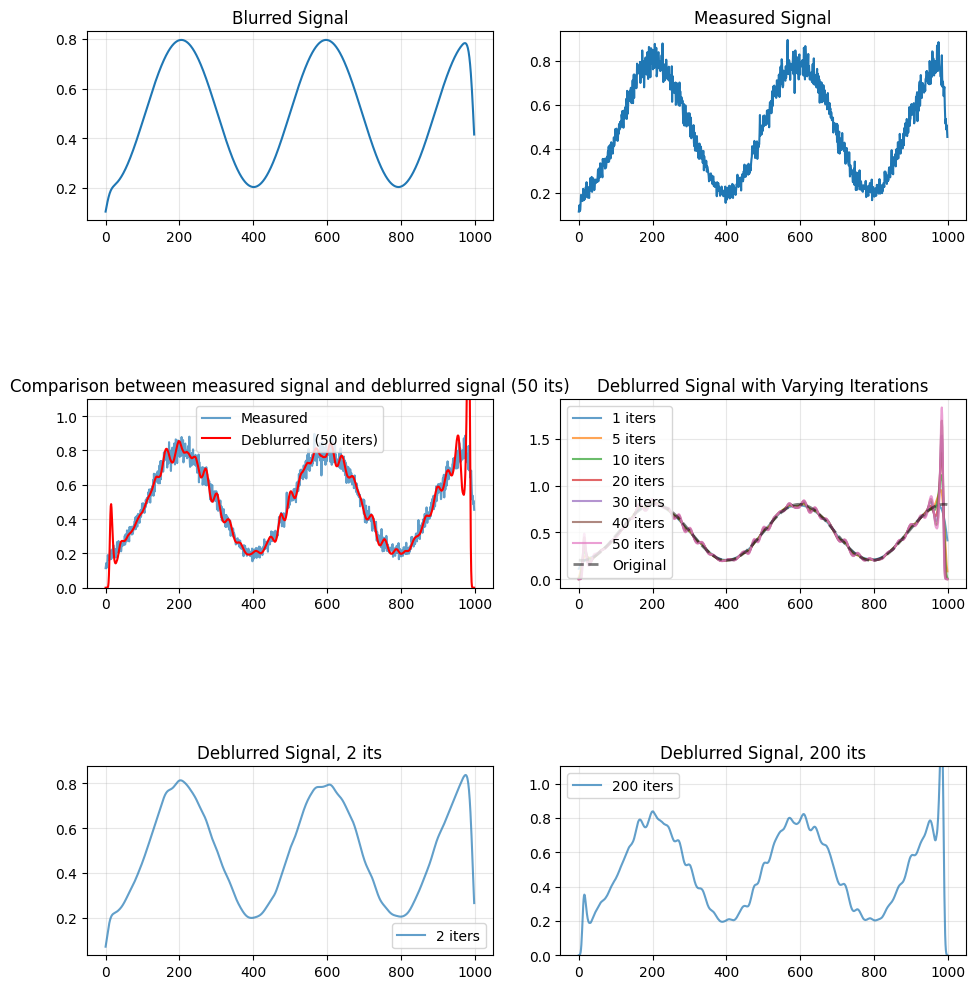

In [40]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10), constrained_layout=False)
fig.subplots_adjust(hspace=10, wspace=6, left=0.06, right=0.98, top=0.95, bottom=0.06)


axs[0, 1].plot(measured_signal)
axs[0, 1].set_title('Measured Signal')
axs[0, 1].grid(True, alpha=0.3)

axs[0, 0].plot(blurred_signal)
axs[0, 0].set_title('Blurred Signal')
axs[0, 0].grid(True, alpha=0.3)



axs[1, 0].plot(measured_signal, label='Measured', alpha=0.7)
deblurred_fixed = richardson_lucy_1d(measured_signal, kernel, num_its=50)
axs[1, 0].plot(deblurred_fixed, label='Deblurred (50 iters)', alpha=1, color = 'red')
axs[1, 0].set_ylim(0, 1.1)
axs[1, 0].set_title('Comparison between measured signal and deblurred signal (50 its)')
axs[1, 0].legend()
axs[1, 0].grid(True, alpha=0.3)



num_iters = [1, 5, 10, 20, 30, 40, 50]
for i in num_iters:
    deblurred_signal = richardson_lucy_1d(measured_signal, kernel, num_its=i)
    axs[1, 1].plot(deblurred_signal.squeeze(), label=f'{i} iters', alpha=0.7)
    
axs[1, 1].plot(y, 'k--', label='Original', linewidth=2, alpha=0.5)
axs[1, 1].set_title('Deblurred Signal with Varying Iterations')
axs[1, 1].legend(loc='best')
axs[1, 1].grid(True, alpha=0.3)



deblurred_signal_2 = richardson_lucy_1d(measured_signal, kernel, num_its=2)
deblurred_signal_200 = richardson_lucy_1d(measured_signal, kernel, num_its=200)

axs[2,0].plot(deblurred_signal_2.squeeze(), label=f'2 iters', alpha=0.7)
axs[2,0].set_title('Deblurred Signal, 2 its')
axs[2,0].legend(loc='best')
axs[2,0].grid(True, alpha=0.3)

axs[2,1].plot(deblurred_signal_20.squeeze(), label=f'200 iters', alpha=0.7)
axs[2,1].set_title('Deblurred Signal, 200 its')
axs[2,1].set_ylim(0,1.1)
axs[2,1].legend(loc='best')
axs[2,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

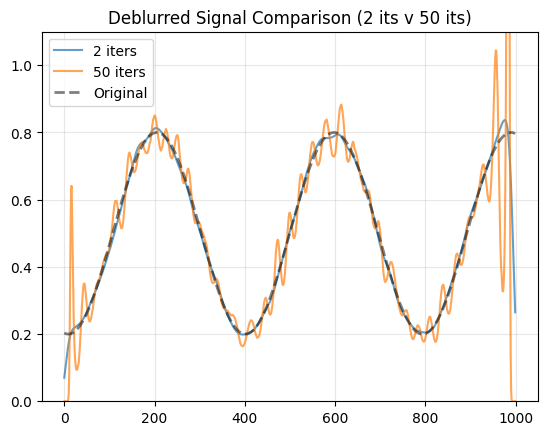

In [41]:

x = torch.linspace(-2, 2, steps=1000)
y = torch.sin(4*x)*0.3 + 0.5
signal = y.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
kernel = gaussian_kernel_1D(size = 61, sigma = 10.0)

blurred_signal = convo1d(signal, kernel)
measured_signal = poisson_noise(blurred_signal, scale_factor=500)

deblurred_signal_100 = richardson_lucy_1d(measured_signal, kernel, num_its=100)



# fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# #cleaned_signal_2 = richardson_lucy_1d(measured_signal, kernel, num_its=2)
# #cleaned_signal_20 = richardson_lucy_1d(measured_signal, kernel, num_its=20)

# axs[0].plot(deblurred_signal_2.squeeze(), label=f'2 iters', alpha=0.7)
# axs[1].plot(deblurred_signal_20.squeeze(), label=f'20 iters', alpha=0.7)

plt.plot(deblurred_signal_2.squeeze(), label=f'2 iters', alpha=0.7)
plt.plot(deblurred_signal_100.squeeze(), label=f'50 iters', alpha=0.7)
plt.plot(y, 'k--', label='Original', linewidth=2, alpha=0.5)
plt.title('Deblurred Signal Comparison (2 its v 50 its)')
plt.legend(loc='best')
plt.ylim(0,1.1)
plt.grid(True, alpha=0.3)
plt.show()

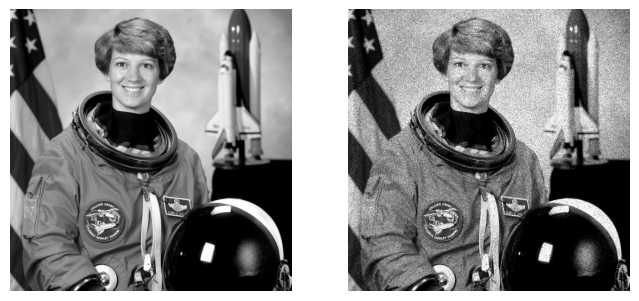

In [42]:

#testing poisson noise function
image_tensor = torch.tensor(image, dtype=torch.float32)
noisy_image_tensor = poisson_noise(image_tensor, scale_factor=50)
noisy_image_np = noisy_image_tensor.numpy()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
ax[0].imshow(image, cmap='gray')
ax[0].axis('off')
ax[1].imshow(noisy_image_np, cmap='gray')
ax[1].axis('off')
plt.show()

C:\Users\Jpjha\AppData\Local\Temp\ipykernel_4384\625580738.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = ((x >= 0) & (x <= 1)) + np.exp(-x**2 / (2 * sigma**2))


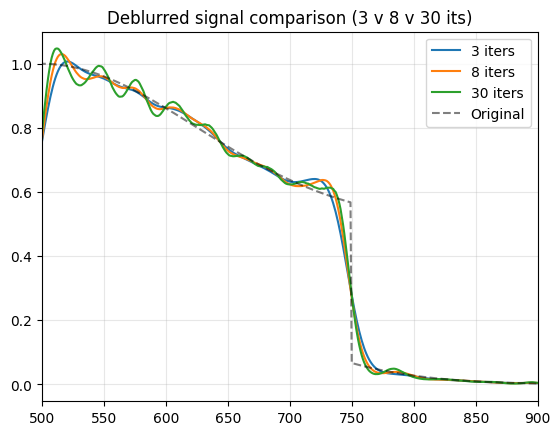

In [89]:
sigma = 0.5
x = torch.linspace(-2, 2, steps=1000)
y = ((x >= 0) & (x <= 1)) + np.exp(-x**2 / (2 * sigma**2))
y = y/2

signal = y.unsqueeze(0).unsqueeze(0)
signal_blur = convo1d(signal, gaussian_kernel_1D(size=61, sigma=10.0))
signal_measured = poisson_noise(signal_blur, scale_factor=500)

cleaned_signal_5 = richardson_lucy_1d(signal_measured, gaussian_kernel_1D(size=61, sigma=10.0), num_its=3)
cleaned_signal_10 = richardson_lucy_1d(signal_measured, gaussian_kernel_1D(size=61, sigma=10.0), num_its=8)
cleaned_signal_30 = richardson_lucy_1d(signal_measured, gaussian_kernel_1D(size=61, sigma=10.0), num_its=30)

plt.plot(cleaned_signal_5.squeeze(), label='3 iters' )
plt.plot(cleaned_signal_10.squeeze(), label='8 iters')
plt.plot(cleaned_signal_30.squeeze(), label='30 iters')
plt.plot(y, 'k--', label='Original', alpha=0.5)
plt.title('Deblurred signal comparison (3 v 8 v 30 its)')
plt.grid(True, alpha =0.3)
plt.xlim(500, 900)
plt.legend()
plt.show()


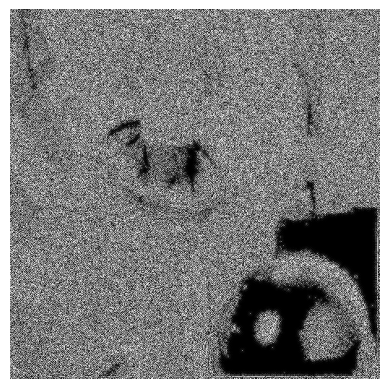

In [117]:
inverse_kernel = torch.flip(gaussian_kernel_2d(size=61, sigma=10.0), [0, 1])
image_noisy = poisson_noise(image_tensor, scale_factor=50)
recovered_signal = deconvolution(image_noisy, kernel)

plt.imshow(recovered_signal, cmap='gray')
plt.axis('off')
plt.show()